In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint
import itertools

from tqdm import tqdm, trange

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import skimage
import cv2 as cv

import quinoa as q

In [2]:
NOTEBOOK_NAME = "segment_individual_seeds"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\quinoa\dev
D:\projects\quinoa\data
D:\projects\quinoa\dev\out\segment_individual_seeds


In [3]:
# img_bgr = q.read_image(DATA / "IMG_0477.JPG")
img_bgr = q.read_image(DATA / "IMG_0497.JPG")
# img_bgr = q.read_image(DATA / "IMG_9465.JPG")

print(img_bgr.shape)

DEBUG:quinoa.io:Loaded image from D:\projects\quinoa\data\IMG_0497.JPG


(2432, 3648, 3)


In [4]:
corners = q.find_card_corners(image_bgr=img_bgr)
new_corners = q.determine_new_corners(corners)
crop_slice = q.corners_to_slice(new_corners)
rectifier = q.get_rectifier(corners, new_corners)

img_bgr_cropped = rectifier(img_bgr)[crop_slice]
img_lab_cropped = q.convert_colorspace(img_bgr_cropped, cv.COLOR_BGR2LAB)

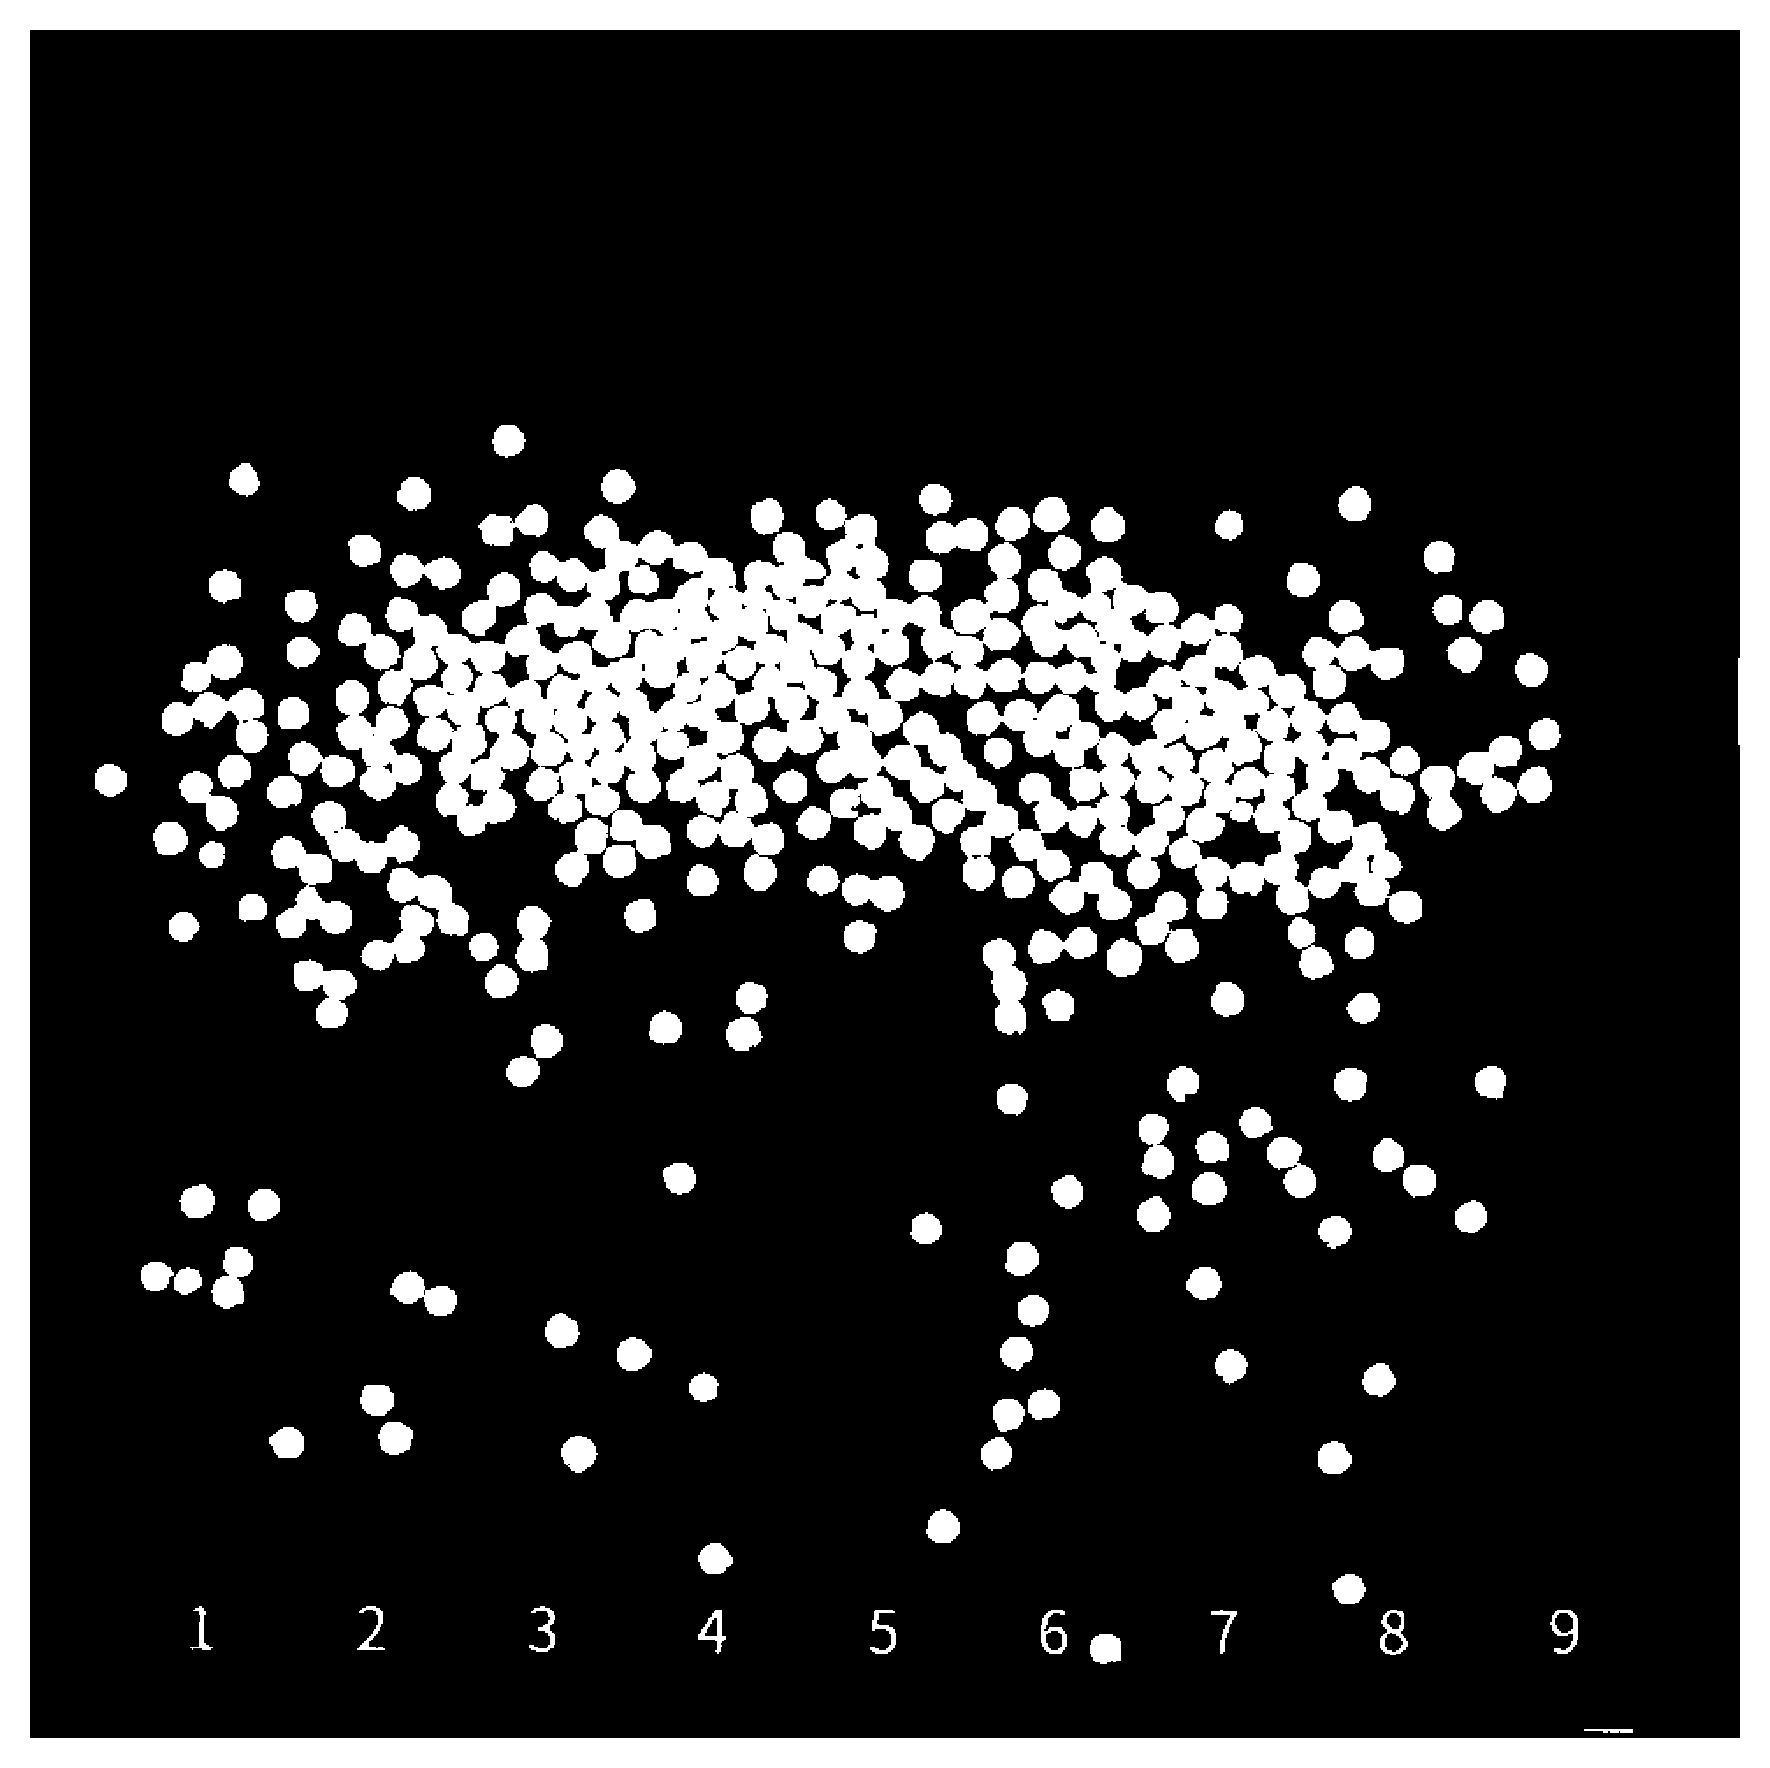

In [5]:
seed_mask, good_markers, seed_labels = q.find_seed_mask(img_lab_cropped)

q.show_image(seed_mask)

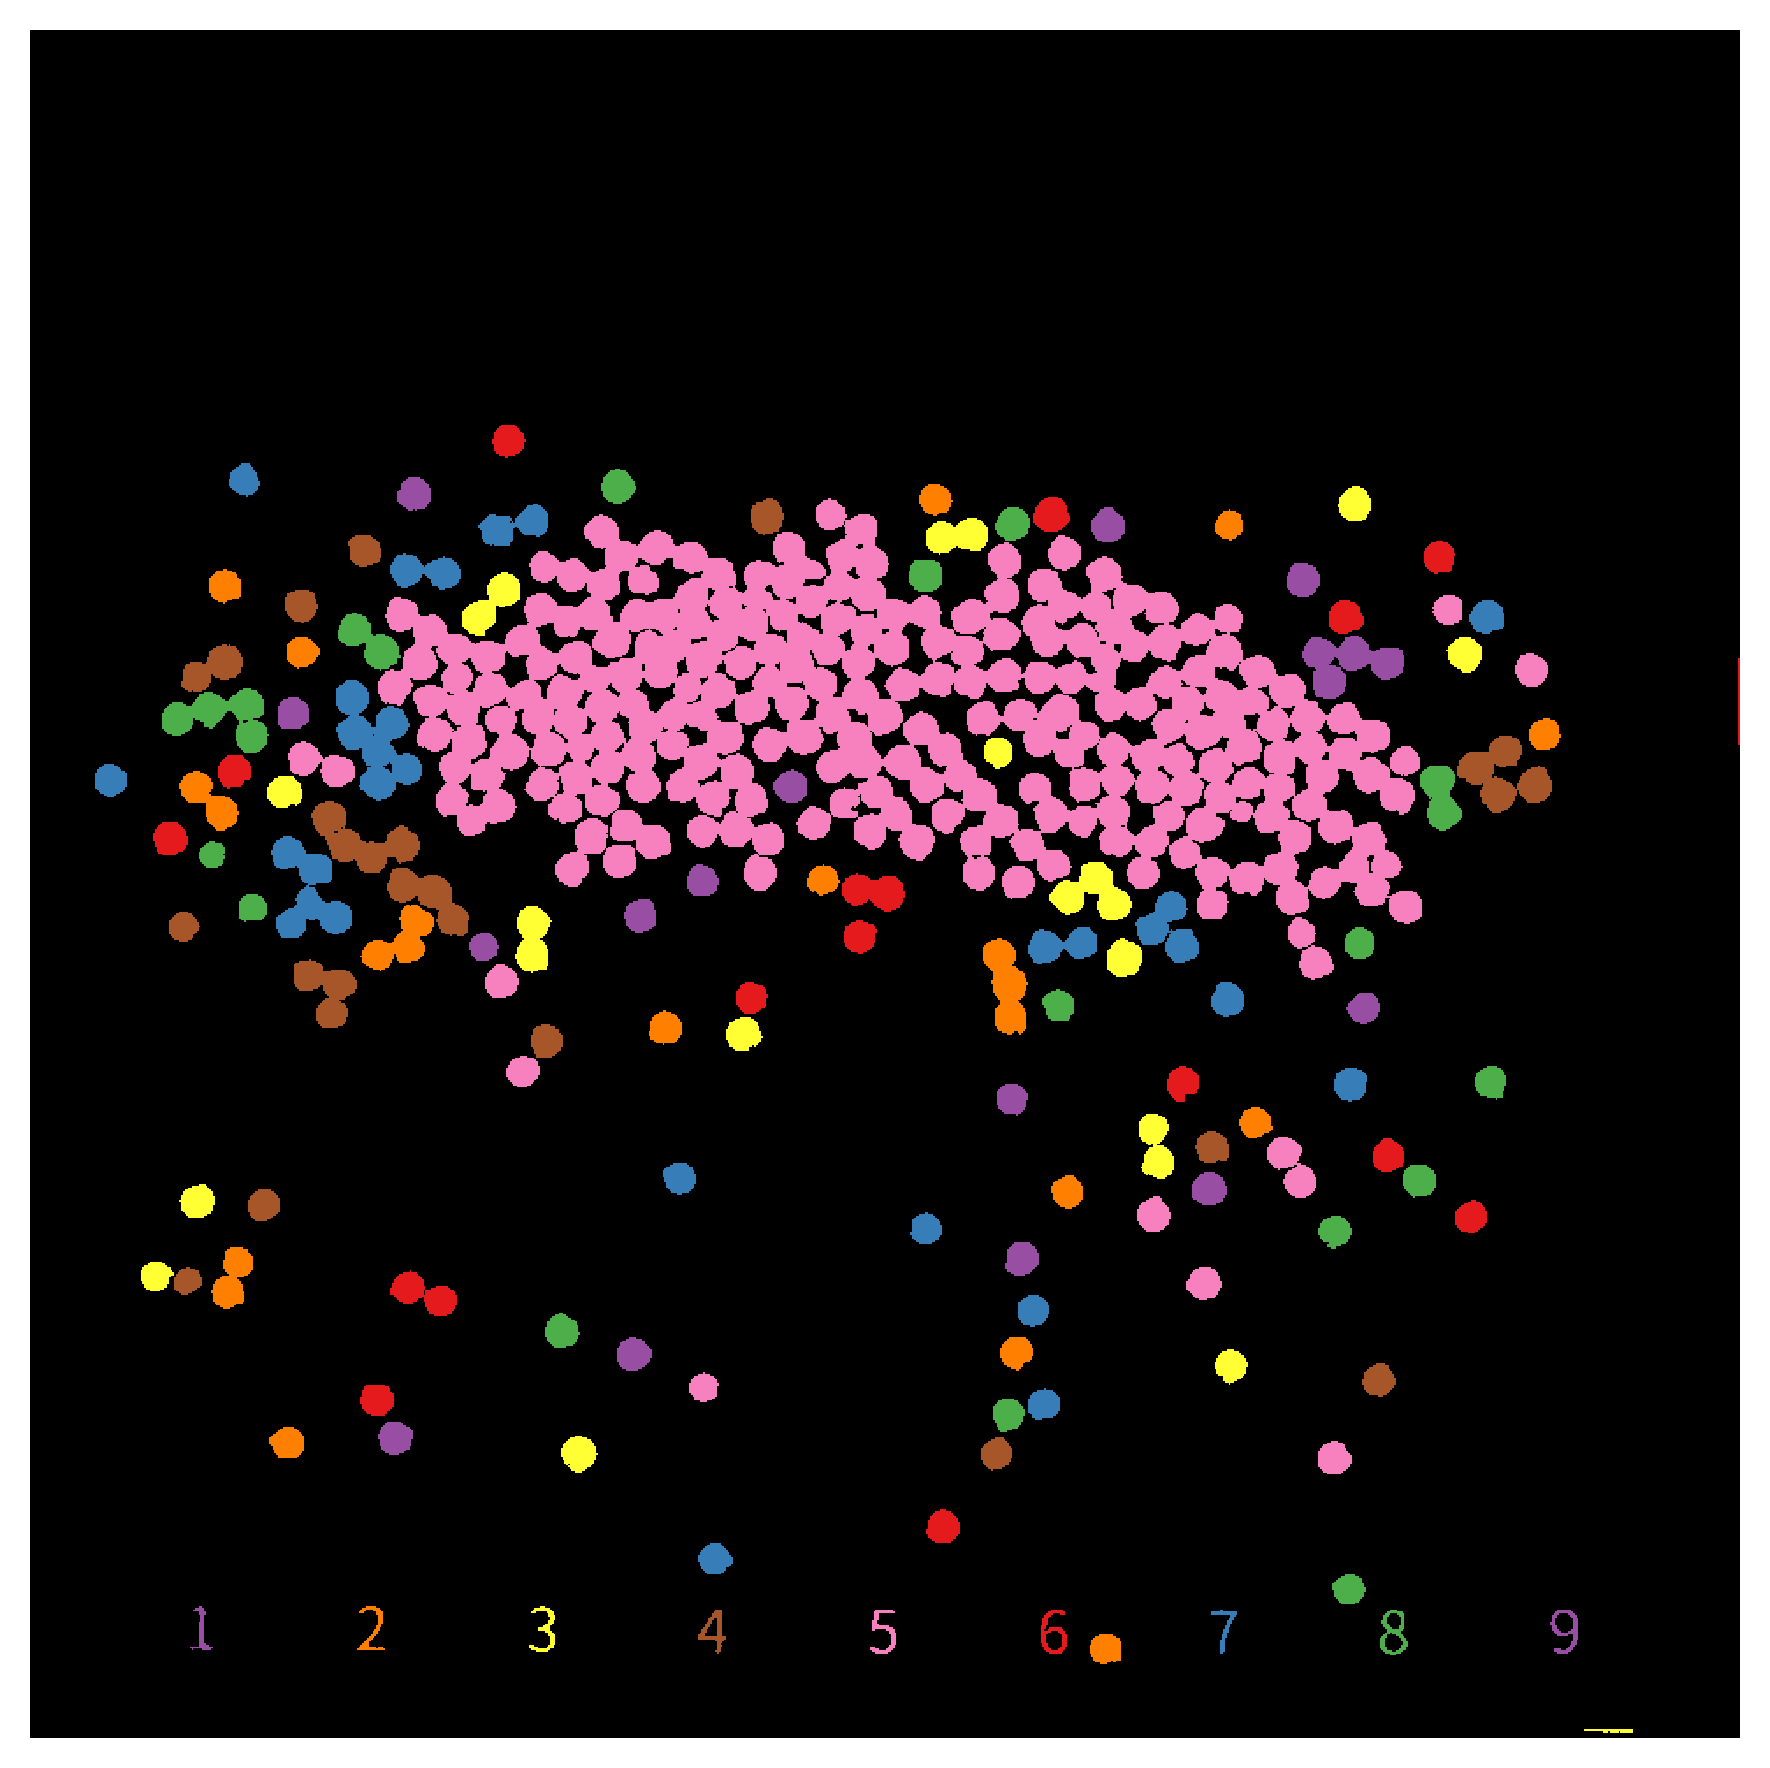

In [6]:
q.show_image(q.color_labels(img_lab_cropped, good_markers, seed_labels))

In [7]:
areas = np.array([
    np.count_nonzero(seed_labels == marker)
    for marker in good_markers
], dtype = np.float64)
print(areas)

[2.7200e+02 2.4200e+02 2.9300e+02 2.8700e+02 2.5700e+02 2.9400e+02
 3.0600e+02 6.4876e+04 3.2100e+02 5.6100e+02 2.9600e+02 2.9800e+02
 2.1300e+02 5.5200e+02 2.7600e+02 2.8800e+02 2.6400e+02 5.6100e+02
 2.9800e+02 2.9700e+02 2.7800e+02 6.0000e+02 2.8200e+02 2.3500e+02
 3.0200e+02 2.9800e+02 6.0500e+02 1.1650e+03 2.5600e+02 3.0300e+02
 5.5800e+02 2.8100e+02 4.9000e+01 1.7250e+03 1.1580e+03 2.7800e+02
 2.5900e+02 2.3100e+02 1.2140e+03 5.7100e+02 2.8300e+02 2.7000e+02
 5.9700e+02 2.7700e+02 5.6400e+02 2.9500e+02 1.1660e+03 9.2100e+02
 3.0400e+02 1.3210e+03 1.7800e+02 2.6100e+02 2.4000e+02 8.7500e+02
 8.6700e+02 2.8300e+02 5.6100e+02 8.1000e+02 2.1300e+02 2.7900e+02
 7.7900e+02 5.8500e+02 2.2600e+02 4.9900e+02 2.7700e+02 5.5900e+02
 2.5000e+02 2.1200e+02 8.9200e+02 3.5000e+02 7.7700e+02 2.8300e+02
 2.5400e+02 2.9500e+02 2.5700e+02 2.5500e+02 2.8500e+02 3.0200e+02
 2.7800e+02 2.6500e+02 2.7100e+02 2.8800e+02 2.6600e+02 2.5400e+02
 2.5400e+02 5.1400e+02 2.7400e+02 5.5700e+02 2.6700e+02 2.6600

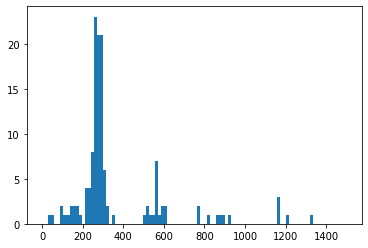

In [8]:
plt.hist(areas, range = (0, 1500), bins = 100)
plt.show()

In [9]:
print(np.median(areas))

282.5


In [10]:
# show_areas = img_bgr_cropped.copy()
# for marker, area in zip(good_markers, areas):
#     y, x = np.transpose(np.nonzero(seed_labels == marker))[0]
#     show_areas = q.draw_text(show_areas, (x, y), str(area), size=0.5)

# print(len(areas))

# q.show_image(show_areas)

In [11]:
# count the number that HAVE THIS AREA (roughly)

sums = []
for area in areas:
    ratios = areas / area
    rounded = np.round(ratios)
    sums.append(np.count_nonzero(rounded == 1))
sums = np.array(sums)

print(sums)

[96 98 95 95 98 95 95  1 93 59 95 95 97 65 96 95 97 59 95 95 96 32 95 99
 95 95 30 17 98 95 59 96  2 10 17 96 98 98 13 49 95 96 32 96 56 95 17 29
 95 13 47 97 98 28 28 95 59 28 97 96 27 44 98 96 96 59 98 96 29 95 26 95
 98 95 98 98 95 95 96 97 96 95 97 98 98 84 96 60 97 97 95 95 97 95 97 95
 97 98 97 95 83 98 70 95 70 98 95 95 96 97 97 98 95 98 97 95 95 93 98 95
 95 97 98  6 10 11 11 11 18  6 22 17 98  2]


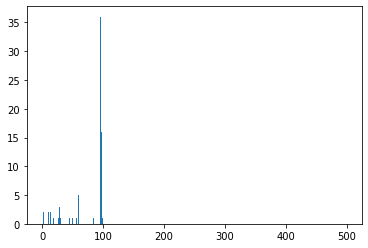

In [12]:
plt.hist(sums, range = (0, 500), bins = 500)
plt.show()

In [13]:
most_common_sum = stats.mode(sums)
print(most_common_sum)
mode = most_common_sum.mode[0]
print(mode)

ModeResult(mode=array([95]), count=array([36]))
95


In [14]:
singleton_markers = [idx for s, idx in zip(sums, good_markers) if s == mode]

print(len(singleton_markers))
print(singleton_markers)

36
[10, 11, 13, 14, 18, 19, 23, 26, 27, 31, 33, 34, 39, 52, 58, 61, 70, 84, 86, 88, 92, 93, 97, 108, 110, 112, 114, 118, 122, 125, 126, 131, 134, 135, 138, 139]


In [15]:
areas_of_singletons = np.array([
    np.count_nonzero(seed_labels == marker)
    for marker in singleton_markers
])

print(areas_of_singletons)

[293 287 294 306 296 298 288 298 297 282 302 298 303 283 295 304 283 350
 283 295 285 302 288 290 304 294 290 291 291 295 294 284 296 283 283 282]


In [25]:
seed_area = np.mean(areas_of_singletons)
# seed_area = np.median(areas)

print(seed_area)

294.0833333333333


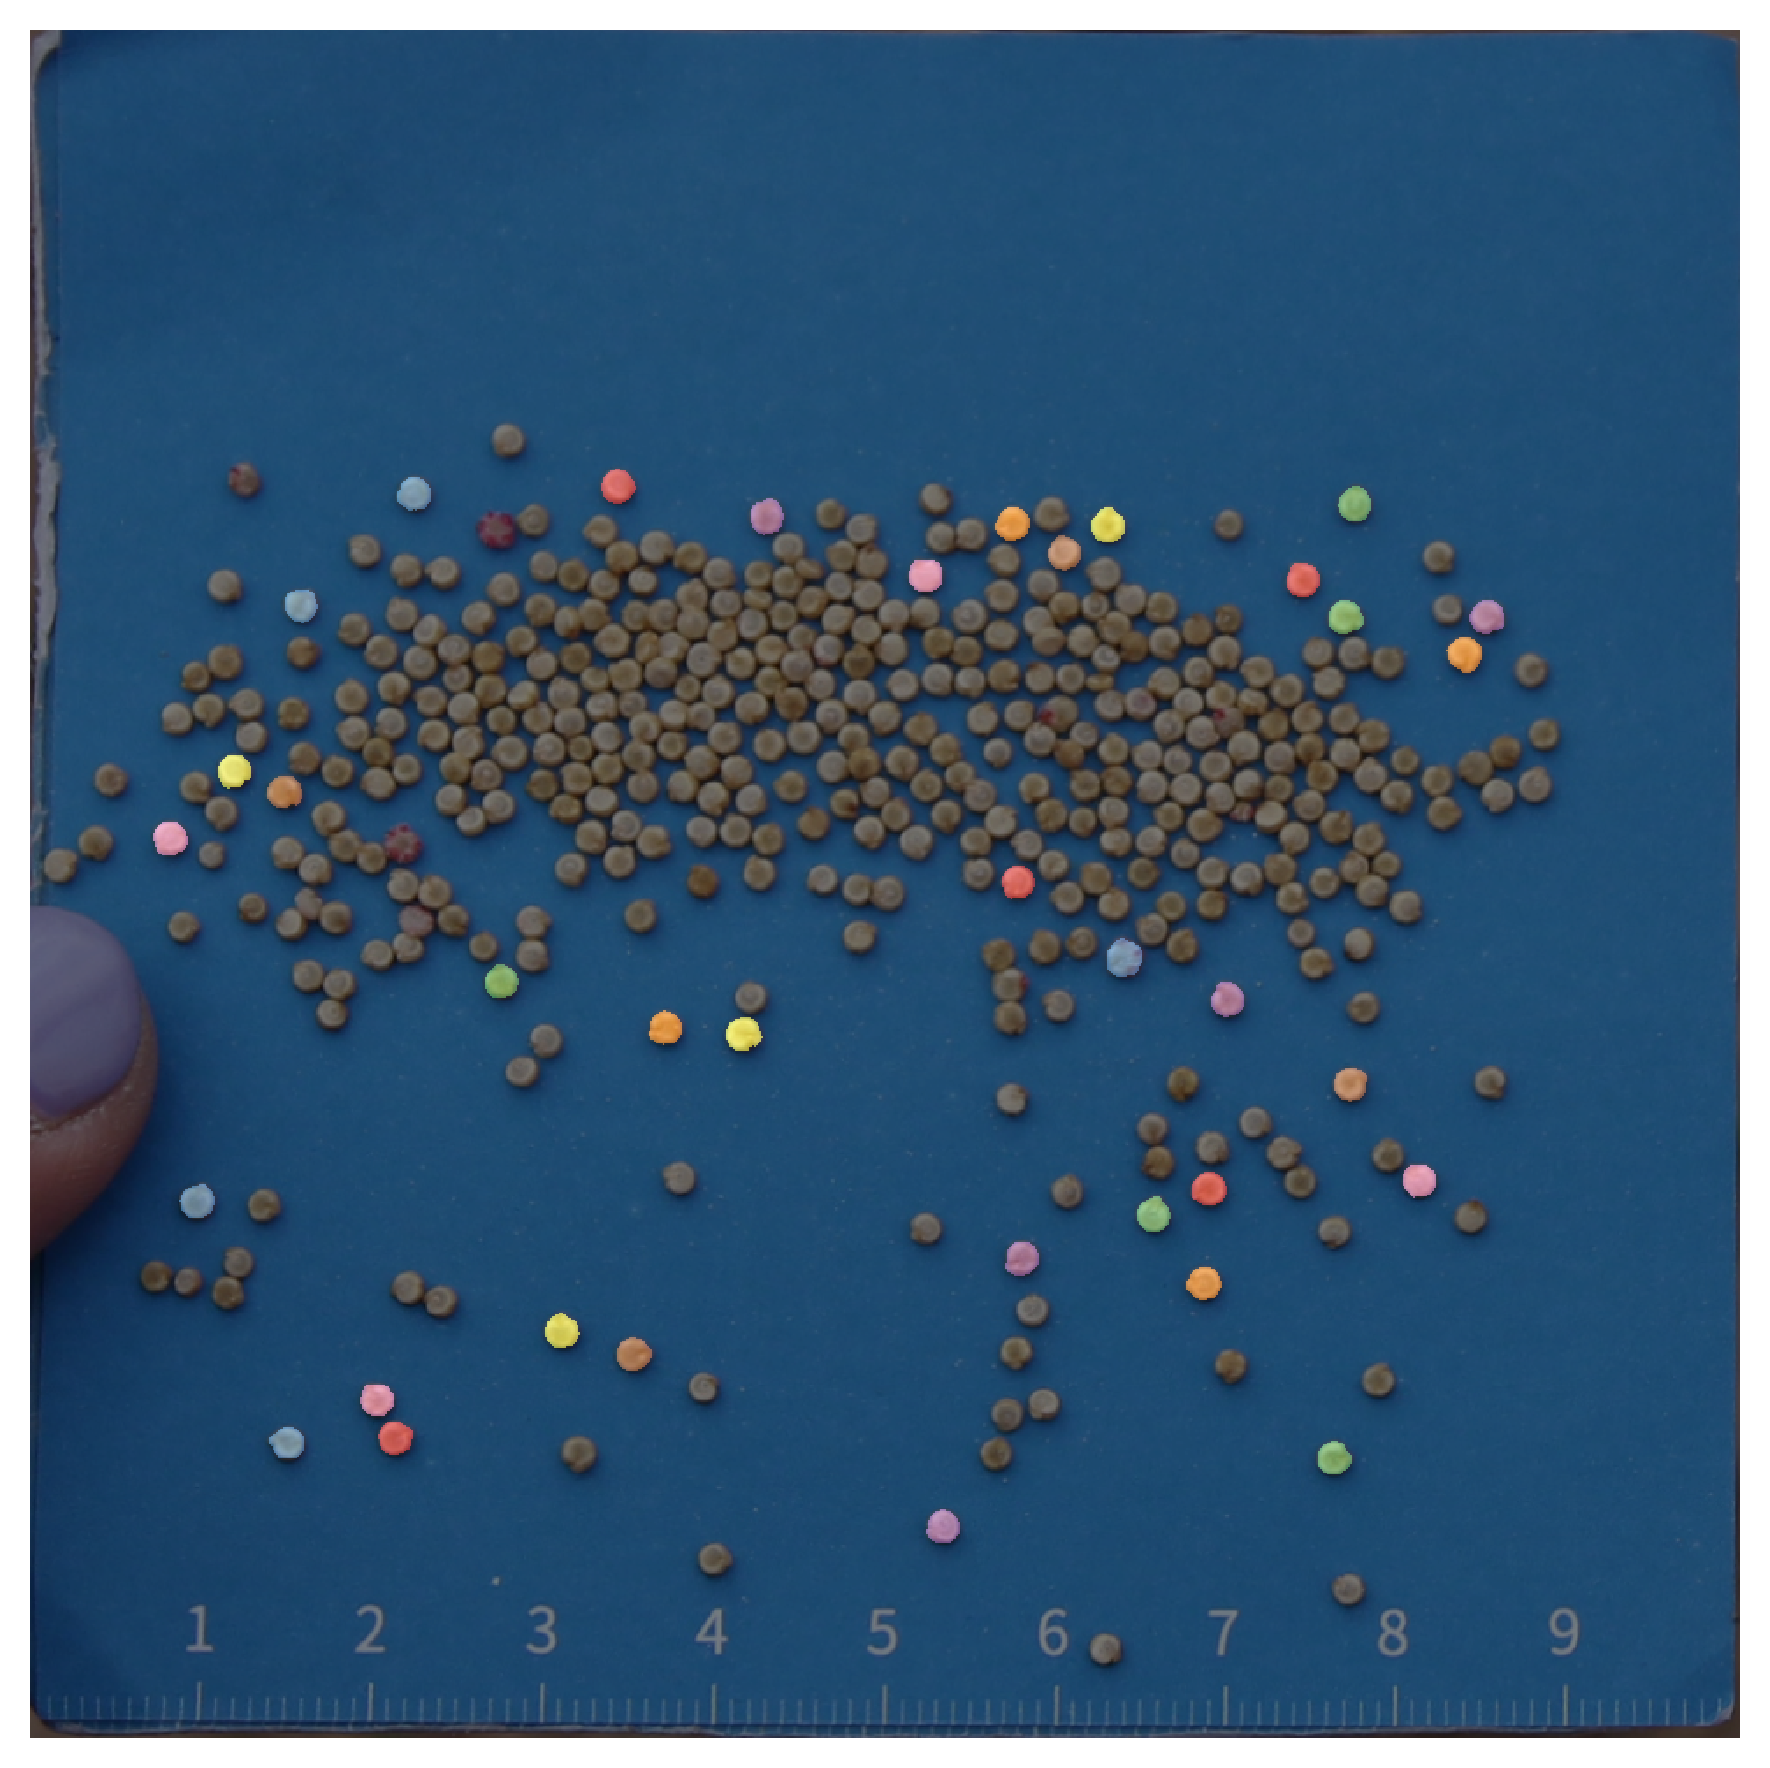

In [26]:
show_single_seeds = q.color_labels(img_bgr_cropped, singleton_markers, seed_labels)

q.show_image(q.overlay_image(img_bgr_cropped, show_single_seeds, 0.5))

In [27]:
areas_of_singletons_again = []
for marker, area in zip(good_markers, areas):
    ratio = int(np.round(area / seed_area))
    if ratio == 1:
        areas_of_singletons_again.append(area)
        
better_seed_area = np.mean(areas_of_singletons_again)
print(better_seed_area)

267.89473684210526


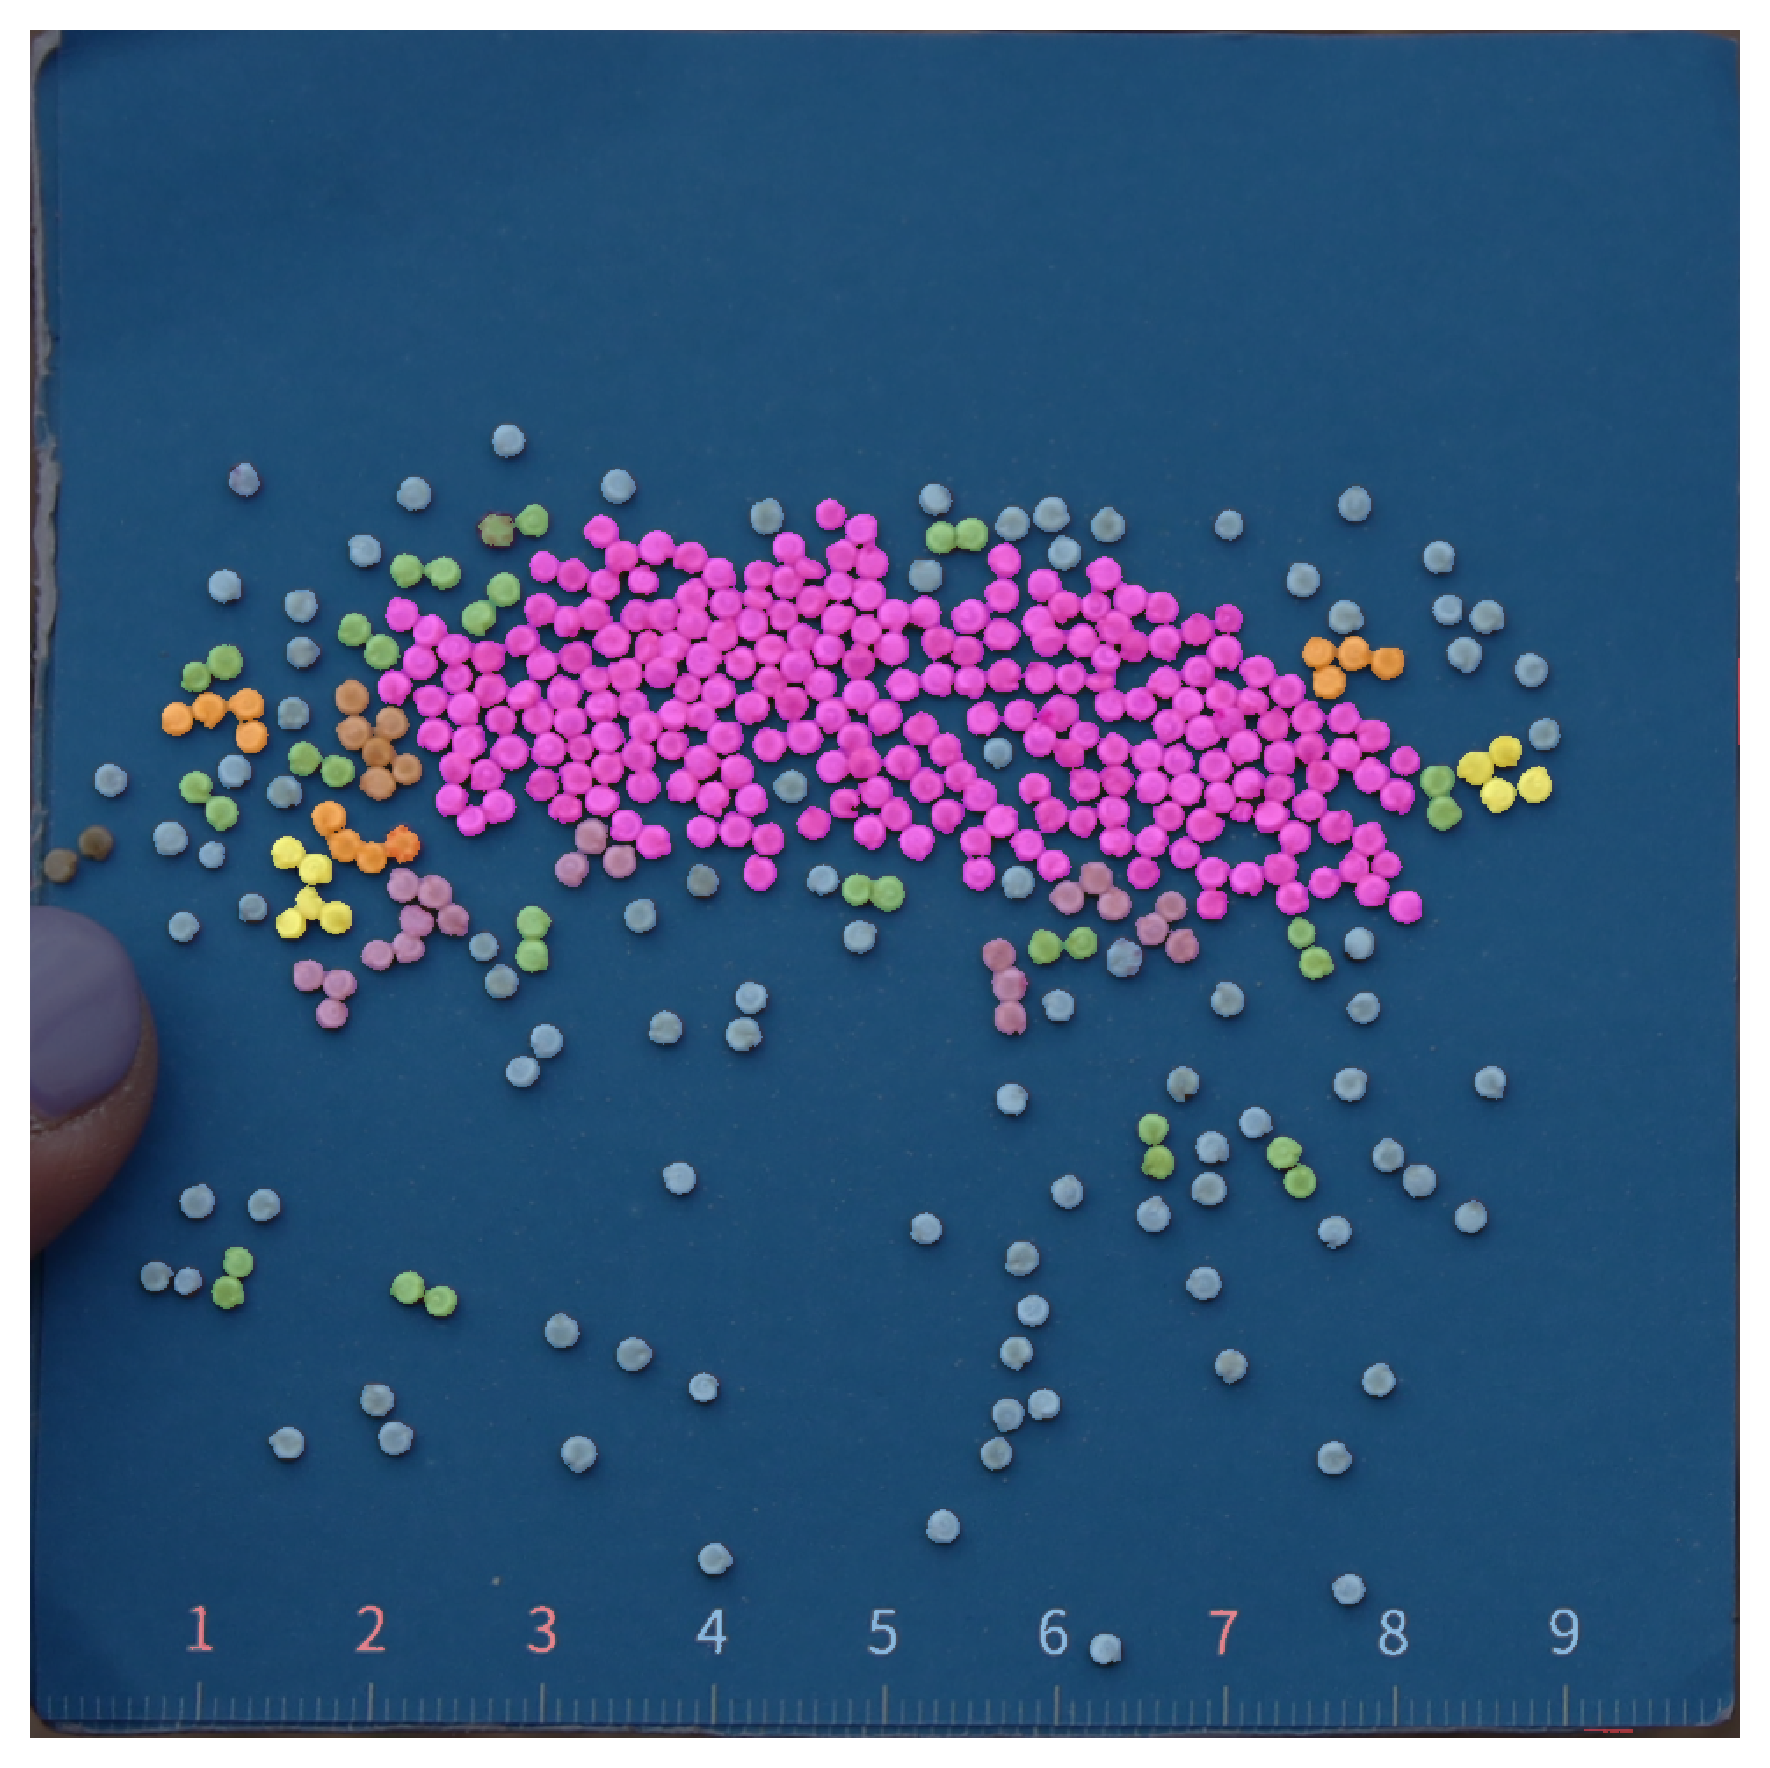

In [29]:
show_counts = np.zeros_like(img_bgr_cropped)

for marker, area in zip(good_markers, areas):
    ratio = int(np.round(area / better_seed_area))
    show_counts[marker == seed_labels] = q.BGR_COLORS[ratio] if ratio < len(q.BGR_COLORS) else q.MAGENTA

q.show_image(q.overlay_image(img_bgr_cropped, show_counts))